In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

In [133]:
data_path = '../../data/agg_unigram/'

In [134]:
fandom_list = [i for i in os.listdir(data_path) if 'tsv' in i]

In [135]:
df = pd.read_csv(os.path.join(data_path, fandom_list[0]), sep = '\t')

In [136]:
df.head(2)

,Author,Hits,Kudos,Title,Words,Bookmarks,CompleteDate,Chapters,UpdateDate,PublishDate,Comments,completed_in_days,Cos
0,CaptainJacq,10372.0,279.0,Graphite Rain: A Love Story in Twelve Parts,144443.0,1188,1547.0,144,NaN,1547,66,0.0,0.019832
1,Afterstory,352.0,15.0,All the King\'s Virtues,49627.0,56,NaN,64,461.0,634,6,NaN,0.019168


In [137]:
d = dict(zip(df.Cos, df.Kudos))

In [138]:
x = [i for i in sorted(d.keys())]
y = [d[i] for i in sorted(d.keys())]

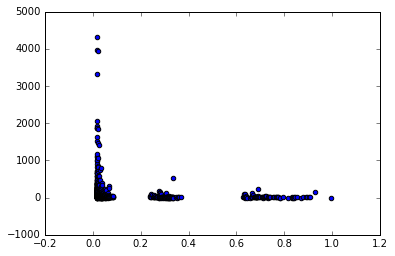

In [139]:
plt.scatter(x, y)

In [140]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

In [141]:
def create_normed_dfs(df):
    
    # Normalize effects of authors by turning kudos into z-score corresponding to works from this author
    # Seems not useful b/c many authors only have 1 work
#     author_list = df.Author.drop_duplicates().tolist()
#     combined = []
#     for author in author_list:
#         df_a = df[df.Author == author]
#         if len(df_a) > 1:
#             df_a['Kudos'] = (df_a['Kudos'] - df_a['Kudos'].mean())/df_a['Kudos'].std(ddof=0)
#             combined.append(df_a)        
#     df = pd.concat(combined)
#     df = df[df.Kudos != 0]

# #     Normalize by creating hits/kudos 
#     df = df[df.Hits != 0]
#     df = df[df.Kudos != 0]
#     df['Kudos/Hits'] = df['Kudos'].astype(float)/df['Hits'].astype(float)
    
#     Normalize by log scale
    df = df[df.Kudos != 0]
    df['Kudos'] = np.log(df['Kudos'])
    df = df[df.Hits != 0]
    df['Hits'] = np.log(df['Hits'])
    df['Kudos/Hits'] = df['Kudos'] - df['Hits']

#     # filter 0s
# #     df = df.fillna(0)"

#     # turn into z scores
#     df['Cos'] = df['Cos'].astype(float)
#     df['Cos'] = (df['Cos'] - df['Cos'].mean())/df['Cos'].std(ddof=0)

    return df

### Plot with bins

In [142]:
def create_dict(fandom_list, field, binsize):
    dict_all = {}
    
    for f in fandom_list:
        df = pd.read_csv(os.path.join(data_path,f), sep = '\t')
        df = create_normed_dfs(df)
        # Make bins
        df.Cos = df.Cos.astype(float)
        min_cos = min(df.Cos.tolist()) - 0.1
        max_cos = max(df.Cos.tolist()) + 0.1
        dic = {}
        for i in np.arange(min_cos, max_cos, binsize):
            df_s = df[(df.Cos >= i) & (df.Cos < i+binsize)]
#             kk_dict[i] = np.average(df_s.Kudos_zscore.tolist())
            if len(df_s) > 0:
                dic[i] = bootstrap_resample(df_s[field].tolist())
        dict_all[f] = dic
    return dict_all

In [143]:
dic = create_dict(fandom_list, 'Kudos', 0.1)

In [144]:
def plot_scatter(fandom_list, dic):
    fig, axs = plt.subplots(5,5, figsize=(30, 20))
    axs = axs.ravel()
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams.update({'axes.titlesize': 'large'})
    
    for i in range(0, len(fandom_list)):
        x = sorted(dic[fandom_list[i]].keys())
        y = [dic[fandom_list[i]][j][0] for j in x]
        
#     Make error bars
        lower_error = [dic[fandom_list[i]][j][0]-dic[fandom_list[i]][j][1] for j in x]
        upper_error = [dic[fandom_list[i]][j][2]-dic[fandom_list[i]][j][0] for j in x]
        asymmetric_error = [lower_error, upper_error]

        axs[i].errorbar(x, y, yerr=asymmetric_error,fmt='o')
        axs[i].plot(x, y, 'o-')
        axs[i].set_title(fandom_list[i].replace('_agg_cos.tsv', ''), fontsize = 20)
#         axs[i].set_xlim([min(x) -1, max(x) + 1])
#         axs[i].set_ylim([min(y) -0.2, max(y) + 0.2])
        for tick in axs[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axs[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
        
        # ax.set_yscale('log')

    fig.text(0.5, 0.06, 'Cosine distance', ha='center', va='center', fontsize=25)
    fig.text(0.08, 0.5, 'Log Kudos', ha='center', va='center', rotation='vertical',fontsize=25)
    
    plt.savefig('cos_log_kudos_agg.png', format = 'png')


In [145]:
def plot_scatter_sq(fandom_list, dic):
    fig, axs = plt.subplots(5,5, figsize=(30, 20))
    axs = axs.ravel()
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams.update({'axes.titlesize': 'large'})
    
    for i in range(0, len(fandom_list)):
        k = sorted([k for k in dic[fandom_list[i]].keys()])
        x = [i*i for i in k]
        y = [dic[fandom_list[i]][j][0] for j in k]
        
#     Make error bars
        lower_error = [dic[fandom_list[i]][j][0]-dic[fandom_list[i]][j][1] for j in k]
        lower_error = [i*i for i in lower_error]
        upper_error = [dic[fandom_list[i]][j][2]-dic[fandom_list[i]][j][0] for j in k]
        upper_error = [i*i for i in upper_error]
        asymmetric_error = [lower_error, upper_error]

        axs[i].errorbar(x, y, yerr=asymmetric_error,fmt='o')
        axs[i].plot(x, y, 'o-')
        axs[i].set_title(fandom_list[i].replace('_agg_cos.tsv', ''), fontsize = 20)
#         axs[i].set_xlim([min(x) -1, max(x) + 1])
#         axs[i].set_ylim([min(y) -0.2, max(y) + 0.2])
        for tick in axs[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in axs[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
        
        # ax.set_yscale('log')

    fig.text(0.5, 0.06, 'Cosine distance squared', ha='center', va='center', fontsize=25)
    fig.text(0.08, 0.5, 'Log Kudos', ha='center', va='center', rotation='vertical',fontsize=25)
    
    plt.savefig('cos_sq_log_kudos_agg.png', format = 'png')


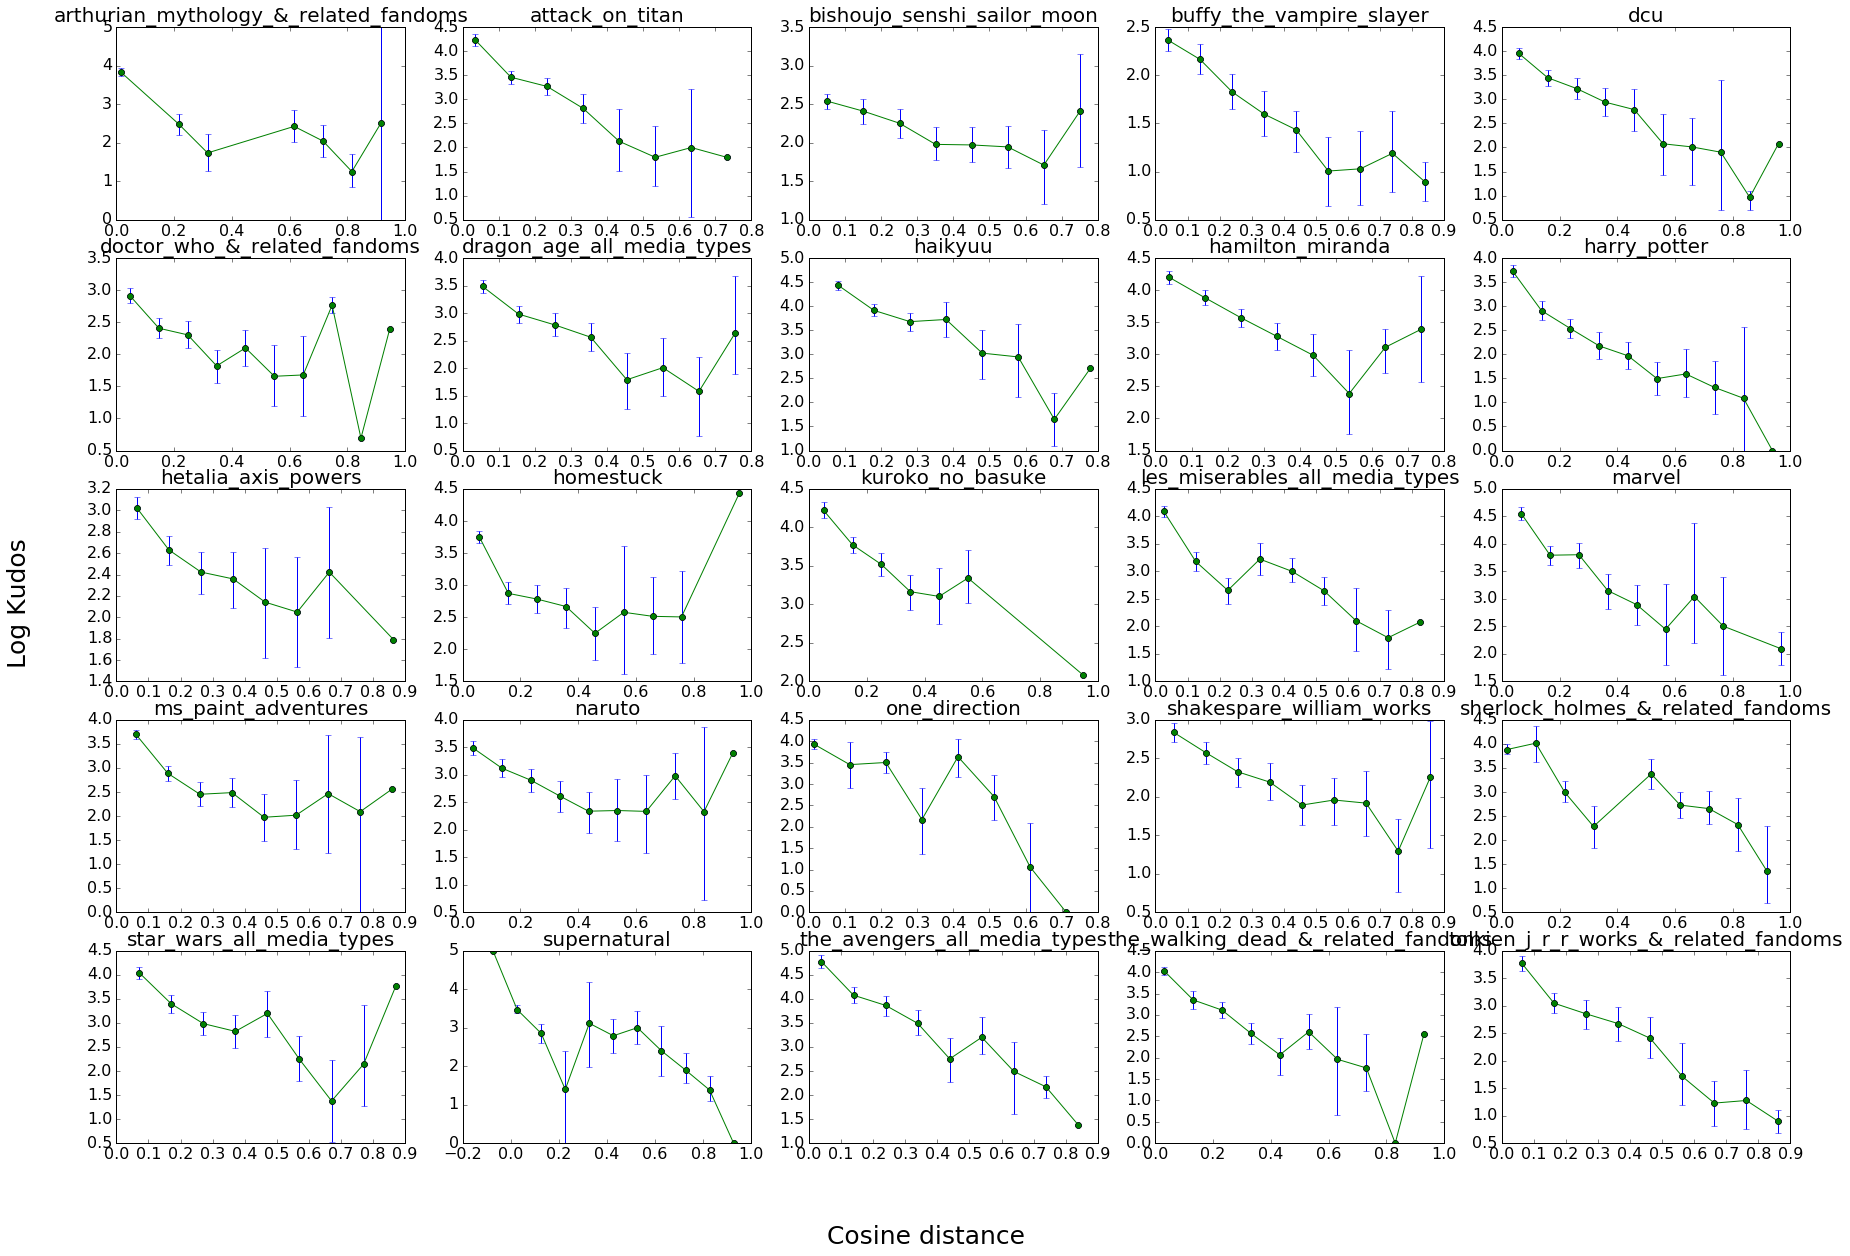

In [146]:
plot_scatter(fandom_list, dic)

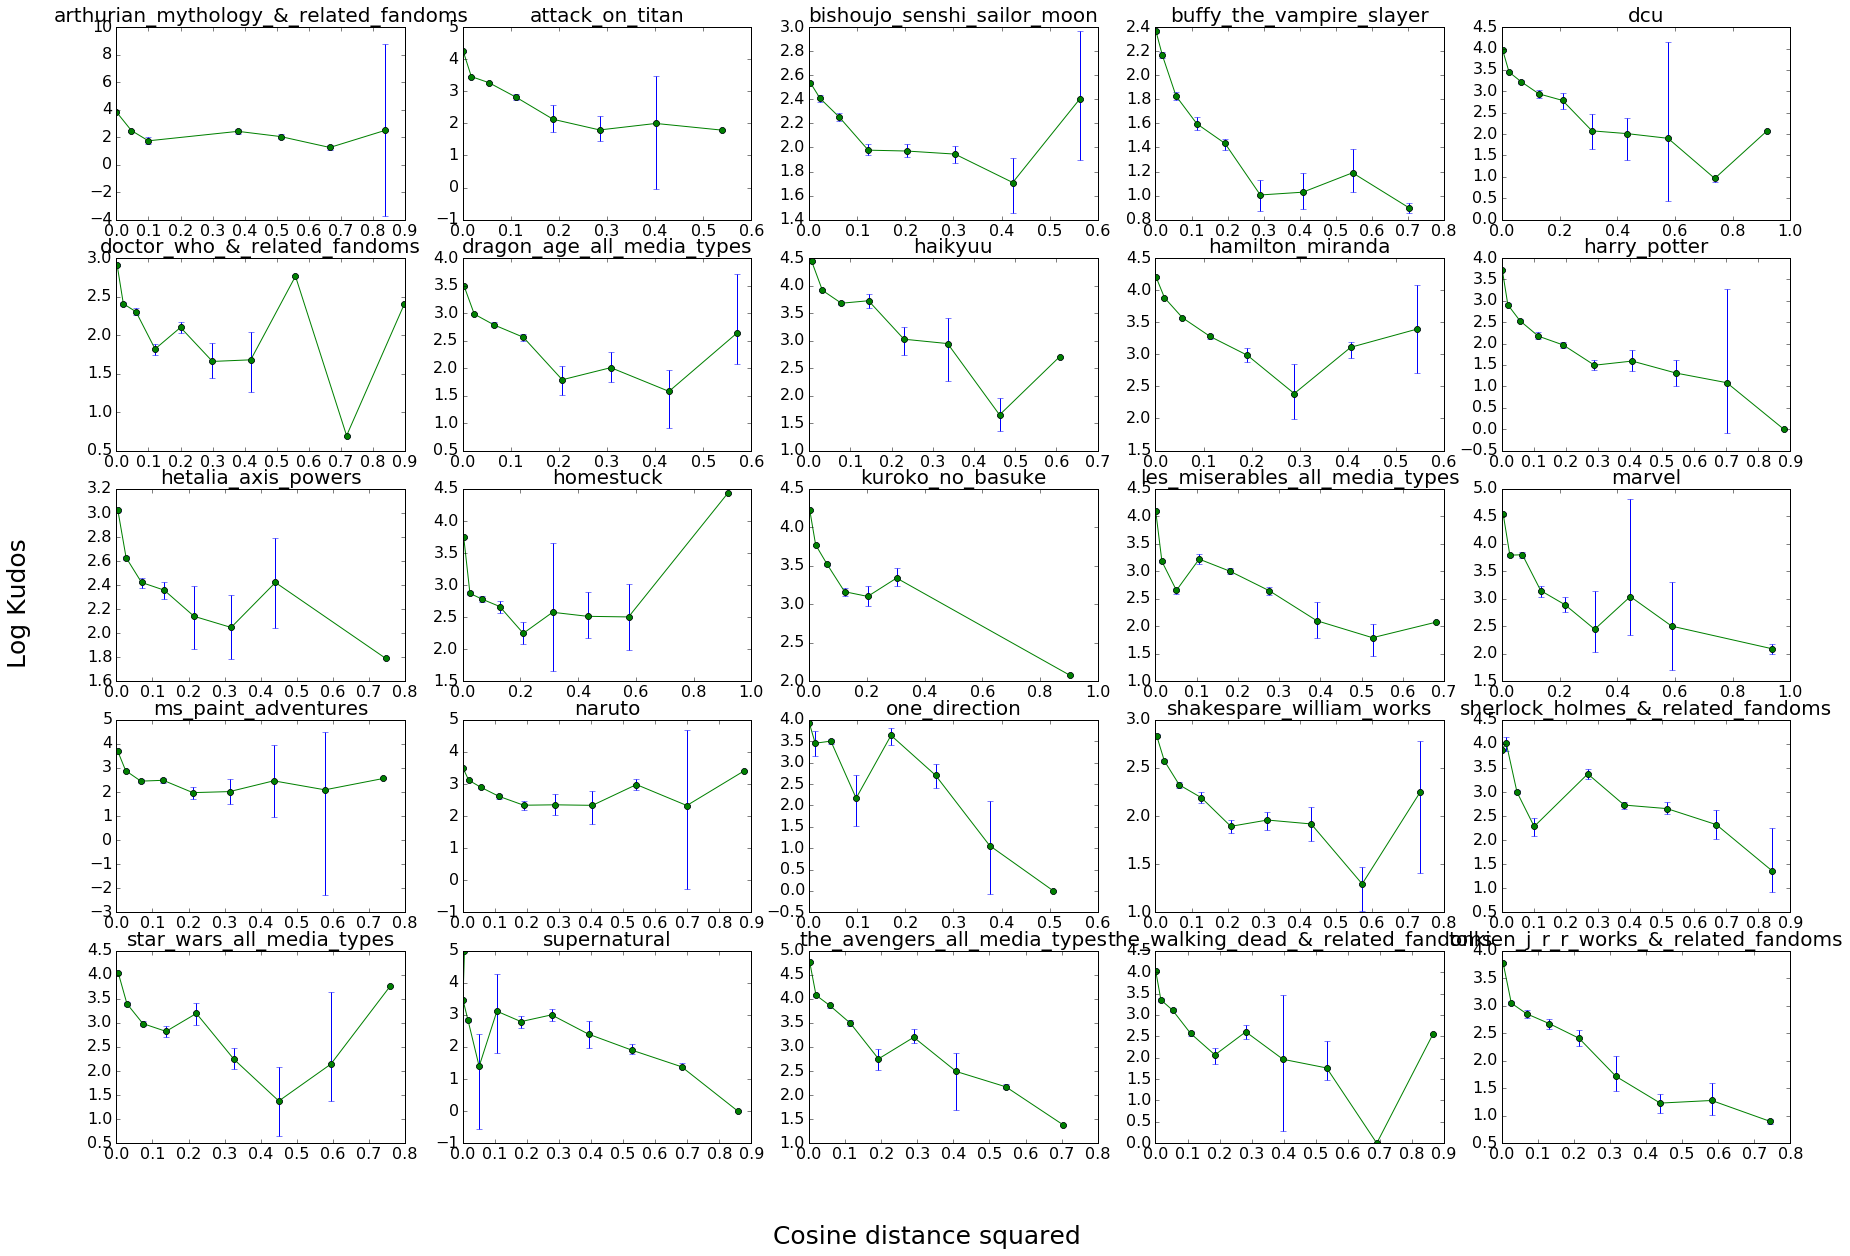

In [147]:
plot_scatter_sq(fandom_list, dic)

### OLS

In [131]:
df.head()

,Author,Hits,Kudos,Title,Words,Bookmarks,CompleteDate,Chapters,UpdateDate,PublishDate,Comments,completed_in_days,Cos
0,dayari,36788.0,757.0,The Ivy Crown,252245.0,1818,2146.0,81,NaN,2146,73,0.0,0.020314
1,MentalHardship,75.0,4.0,Bryopsida,740.0,0,528.0,1,NaN,528,0,0.0,0.266596
2,sky_reid,1680.0,54.0,At the End of the Day,1859.0,4,1626.0,1,NaN,1626,5,0.0,0.030596
3,NaomyM,432.0,23.0,Keep it Simple,8973.0,1,1229.0,1,NaN,1229,1,0.0,0.017419
4,Mizufae,5938.0,136.0,Art and Graphics for There Are No Gays In Foot...,2288.0,7,1577.0,1,NaN,1577,11,0.0,0.035514
